# The Physical Layer as an Autoencoder


**First : change the runtime and hardware acceleration**

Runtime $\rightarrow$ Change runtime type

- Runtime type : Python 3
- Hardware accelerator : GPU

An autoencoder is a type of artificial neural network used to find a useful representation of some data $\mathbf{s}$ at an intermediate layer $\mathbf{x}$ through learning to reproduce the input at the output.

![autoencoder_0](https://github.com/mgoutay/autoencodeur/blob/master/Images/autoencoder_0.png?raw=true)



# Initialisation

In [45]:
# Install TensorFlow 2.0 on Google Collab if needed
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

In [46]:
#Set the GPU you want to use
num_GPU = 0

import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

gpus = tf.config.experimental.list_physical_devices("GPU")
print('Number of GPUs available :', len(gpus))

if num_GPU < len(gpus):
    tf.config.experimental.set_visible_devices(gpus[num_GPU], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[num_GPU], True)
    print('Only GPU number', num_GPU, 'used')

Tensorflow version:  2.0.0
Number of GPUs available : 4
Only GPU number 0 used


In [47]:
import os
import copy
import sys
import time
from datetime import datetime

import numpy as np
import matplotlib
import matplotlib.pyplot as plt  

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense, Lambda
from tensorflow.keras.regularizers import Regularizer

# Communicating messages

**An autoencoder-based communication systems aims to implement the transmitter, channel, and receiver as a single NN which reconstructs its input at its output**

The goal is to learn a modulation wich will be robust with respect to the perturbations introduced by the channel.

The channel is implemented as a "Noise Layer" without any learnable parameters, wich must be differentiable in order to perform SGD on the transmitter's parameters.

Examples:

- AWGN channel : $\mathbf{y} = \mathbf{x} + \mathbf{w}$

- Memoryless fading channel : $\mathbf{y} = h \mathbf{x} + \mathbf{n} $
- ...

![autoencoder](https://github.com/mgoutay/autoencodeur/blob/master/Images/autoencoder.png?raw=true)

First, let's transmit messages.

The first hyper-parameters to set are the total number of messages $M$ and the number of channel uses $N_c$

It can be seen that $M$ can also be seen as the modulation order. Indeed, sending one out of $M$ message is equivalent to sending $\log_2(M)$ bits.

We will implement the fowllowing network:
![model_0](https://github.com/mgoutay/autoencodeur/blob/master/Images/model_0.png?raw=true)

In [269]:
# Number of messages
M = 16

# Number of channel uses
ch_uses = 1

## Define the layers

In [270]:
class Transmitter(Layer):

    def __init__(self, M, ch_uses=1, **kwargs):
        super(Transmitter, self).__init__(**kwargs)
        self.M = M
        self.ch_uses = ch_uses

    def build(self, input_shape):
        self.emb_table = self.add_weight(shape=[self.M, 2*self.ch_uses], 
                                          initializer='random_normal',
                                          trainable=True)

    def call(self, messages):
        #Embedding
        self.x = tf.nn.embedding_lookup(self.emb_table, messages)
        
        # Normalize power per symbol to 1
        self.en_moy =tf.sqrt(2 * tf.reduce_mean(tf.square(self.emb_table)))
        self.x_norm = tf.divide(self.x, self.en_moy)
        
        #Real to complex
        self.x_cplx = tf.complex(self.x_norm[:, :int(self.ch_uses)], self.x_norm[:, int(self.ch_uses):])
            
        return self.x_cplx

In [271]:
class Channel(Layer):

    def __init__(self, **kwargs):
        super(Channel, self).__init__(**kwargs)

    def call(self, x, noise_stddev):
            
        self.noise_r = tf.random.normal(shape = tf.shape(x), stddev = 1) * noise_stddev/tf.sqrt(2.)
        self.noise_i = tf.random.normal(shape = tf.shape(x), stddev = 1) * noise_stddev/tf.sqrt(2.)
        self.noise_cplx = tf.complex(self.noise_r, self.noise_i, name="noise")
        
        self.y = x + self.noise_cplx
            
        return self.y

In [272]:
class Receiver(Layer):

    def __init__(self, M, **kwargs):
        super(Receiver, self).__init__(**kwargs)
        self.M = M

    def build(self, input_shape):
        self.dense_0 = Dense(4*self.M, activation = tf.nn.relu)
        self.dense_1 = Dense(2*self.M, activation = tf.nn.relu)
        self.dense_2 = Dense(self.M, activation = None)

    def call(self, y):
        # Complex to Real
        self.y_real = tf.concat([tf.math.real(y), tf.math.imag(y)], axis=1)
        
        #Dense layers
        self.d_0 = self.dense_0(self.y_real)
        self.d_1 = self.dense_1(self.d_0)
        self.d_2 = self.dense_2(self.d_1)
        
        #Softmax
        self.p_m = tf.nn.softmax(self.d_2)
        
        return self.p_m

## Define the model

In [273]:
class Autoencoder(Model):

    def __init__(self, M, ch_uses=1, **kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        self.M = M
        self.ch_uses = ch_uses

    def build(self, input_shape):
        self.tx = Transmitter(self.M, self.ch_uses)
        self.ch = Channel()
        self.rx = Receiver(self.M)
    
    def call(self, inputs):
        
        self.messages, self.snr = inputs
        
        self.noise_stddev = tf.sqrt( 2 / tf.pow(10., self.snr/10.0))
        
        self.x = self.tx(self.messages)
        self.y = self.ch(self.x, self.noise_stddev)
        self.p_m = self.rx(self.y)
        
        return self.p_m

## Instantiate the autoencoder

In [274]:
# SNR at training
training_snr = 15

# Instantiate an autoencoder
autoencoder = Autoencoder(M, ch_uses)

#Initialize optimizer
optimizer = tf.keras.optimizers.Adam()

## Generate messages

In [275]:
def generate_ds_msg(epoch_len, batch_size, M, training_snr):
    'Generate epoch_len batches of messages'
    
    rand_msg = tf.random.uniform(shape=[epoch_len, batch_size], minval=0, maxval=M, dtype=tf.int32)
    msg_ds = tf.data.Dataset.from_tensor_slices(rand_msg)
    snr_ds = tf.data.Dataset.from_tensor_slices(training_snr*tf.ones(shape=[epoch_len, batch_size, 1]))
    
    features_ds = tf.data.Dataset.zip((msg_ds, snr_ds))
    labels_ds = msg_ds
    return (features_ds, labels_ds)

## What about the loss function?

The loss function is the **sparse** (there is only one good class) **categorical cross-entropy**:

$$
\begin{align*}
L(\theta_T, \theta_R) &= \mathbb{E}_{m, y}[ - \log(\hat{p_{\theta_R}}(m | y)) ], y \thicksim p(y|x)\\
&= H(m) - I_{\theta_T}(m; y) + \mathbb{E}_{s, y} [ D_{KL} (p_{\theta_R}(m|y) || \hat{p_{\theta_R}}(m|y)) ]\\
\end{align*}
$$

- $H(m)$ is the entropy  of the source

- $I_{\theta_T}(m; y) = I_{\theta_T}(m; y)$ is the mutual information between the sent and the received symbols

- $D_{KL} (p_{\theta_R}(m|y) || \hat{p_{\theta_R}}(m|y))$ is the KL-Divergence between the true and the predicted distributions

Hence, minimizing the sparse categorical cross-entropy loss both maximize the mutual information and minimize the KL-divergence between the true and the predicted distribution

In [276]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()

## Train

In [277]:
batch_size = 10000
epoch_size = 100
nb_epoch = 10

print('SER after each epoch:')

start_time = time.time()
for epoch in range(nb_epoch):
    
    # Create a dataset for each epoch
    dataset = tf.data.Dataset.zip(generate_ds_msg(epoch_size, batch_size, M, training_snr))

    # Iterate over the batches of the dataset.
    for step, (features, labels) in enumerate(dataset):
        # Open a GradientTape.
        with tf.GradientTape() as tape:

            # Forward pass.
            p_m = autoencoder(features)

            # Loss value for this batch.
            loss_value =  loss_func(y_true=labels, y_pred=p_m)

        # Get gradients of loss wrt the weights.
        gradients = tape.gradient(loss_value, autoencoder.trainable_weights)

        # Update the weights of our linear layer.
        optimizer.apply_gradients(zip(gradients, autoencoder.trainable_weights))
    
    #Take the argmax of the probability distribution as the estimated message
    m_hat = tf.argmax(p_m, axis=1, output_type=tf.int32)
    
    ser = tf.reduce_sum(tf.clip_by_value(tf.abs(labels-m_hat), 0, 1))/(batch_size)
    print(ser.numpy(), end=', ')

print("\n\nExecution time : %s seconds" % (time.time() - start_time))

SER after each epoch:
0.4922, 0.2749, 0.1728, 0.1219, 0.1097, 0.1097, 0.1057, 0.1073, 0.1039, 0.1075, 

Execution time : 17.143022537231445 seconds


## Evaluate the model

In [278]:
snr_range = np.arange(-5, 21)
results=[]
bs_eval = 100000

for eval_snr in snr_range:
    
    batch_msg = tf.random.uniform(shape=[bs_eval], minval=0, maxval=M, dtype=tf.int32)
    batch_snr = eval_snr*tf.ones(shape=[bs_eval, 1])
    
    p_m = autoencoder([batch_msg, batch_snr])
    m_hat = tf.argmax(p_m, axis=1, output_type=tf.int32)
    
    ser = tf.reduce_sum(tf.clip_by_value(tf.abs(batch_msg-m_hat), 0, 1))/(bs_eval)
    print(eval_snr, end=', ')
    results.append(ser.numpy())

-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 

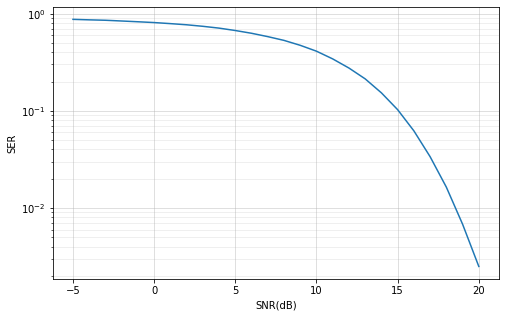

In [279]:
plt.figure(figsize=(8, 5))
plt.semilogy(snr_range, results)
plt.xlabel('SNR(dB)')
plt.ylabel('SER');
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.25)

## See learned constellation

In [286]:
# Form a batch containing every message
batch_msg = tf.cast(tf.linspace(0., M-1, M), tf.int32)
batch_snr = training_snr*tf.ones(shape=[M, 1])

p_b = autoencoder([batch_msg, batch_snr])

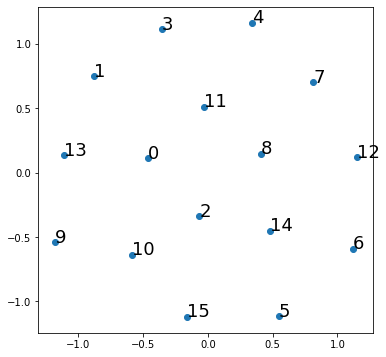

In [289]:
msg_np = batch_msg.numpy()
x_np = autoencoder.x.numpy()
plt.figure(figsize=(6,6))
plt.scatter(np.real(x_np), np.imag(x_np))
for i in range(np.shape(x_np)[0]) :
    plt.text(np.real(x_np[i]), np.imag(x_np[i]), str(msg_np[i]), fontsize=18)

# Communicating bits

We now want to transmit bits. But how to optimally label them?

![label](https://github.com/mgoutay/autoencodeur/blob/master/Images/which_bits.png?raw=true)


Let's say we want to send $K$ bits over $N_c$ chanel uses (sending $K$ bits is equivalent to sending one out of $M = 2^K$ messsages) .

**An information theory perspective :**

![bits_0](https://github.com/mgoutay/autoencodeur/blob/master/Images/bits_0.png?raw=true)

$$
\begin{align*}
I(X;Y) &= I(\mathbf{B};Y)\\
&= H(\mathbf{B}) - H(\mathbf{B}|Y)\\
&= \sum_{k=1}^{K} H(B_k | B_{k-1}, ..., B_1) - \sum_{k=1}^{K} H(B_k | Y, B_{k-1}, ..., B_1) \\
\end{align*}
$$

If we want to maximize the mutual information between $X$ and $Y$ (or equivalently between $B$ and $Y$ as there is a direct mapping from $B$ to $X$), we need:

* Multistage decoding at the receiver
* Multilevel coding at the transmitter

which is highly not practical

A widly used simplification is to only consider the rate $R$:

![bits_2](https://github.com/mgoutay/autoencodeur/blob/master/Images/bits_2.png?raw=true)

![bits_3](https://github.com/mgoutay/autoencodeur/blob/master/Images/bits_3.png?raw=true)

$R$ is achievable using:
* Bit-metric decoding at the receiver
* Bit interleaved coded modulation at the transmitter

In [248]:
# Number of bits per symbols
K = 4

# Number of channel uses
ch_uses = 1

## Define Layers

We will use the same models than for the transmission of messages with a few modification:
* The transmitter now accepts a vecot or $K$ bits
* The receiver ouputs Log Likelihood Ratios for each of the $K$ bits
* Those LLRs are then passed through a sigmoid function to ouptut $\hat{p}_{\theta_{R}}(b_k|y)_{k=1, ..., K}$

![bits_4](https://github.com/mgoutay/autoencodeur/blob/master/Images/bits_4.png?raw=true)


In [249]:
class Transmitter(Layer):

    def __init__(self, K, ch_uses=1, **kwargs):
        super(Transmitter, self).__init__(**kwargs)
        self.K = K
        self.M = int(2**self.K)
        self.ch_uses = ch_uses
        
        # Vector [2^K, ..., 2^1, 2^0]
        self.bin_conv = tf.convert_to_tensor(np.flip([np.power(2, i) for i in range(self.K)]).astype(np.int32))

    def build(self, input_shape):
        self.emb_table = self.add_weight(shape=[self.M, 2*self.ch_uses], 
                                          initializer='random_normal',
                                          trainable=True)

    def call(self, bits):
        # Find the messages m \in {0, ..., M-1} corresponding to each vector of K bits
        self.m = tf.reduce_sum(bits*tf.expand_dims(self.bin_conv,axis= 0), axis=1)
        
        # Embedding
        self.x = tf.nn.embedding_lookup(self.emb_table, self.m)
        
        # Normalize power per symbol to 1
        self.en_moy =tf.sqrt(2 * tf.reduce_mean(tf.square(self.emb_table)))
        self.x_norm = tf.divide(self.x, self.en_moy)
        
        #Real to complex
        self.x_cplx = tf.complex(self.x_norm[:, :int(self.ch_uses)], self.x_norm[:, int(self.ch_uses):])
            
        return self.x_cplx

In [250]:
class Channel(Layer):

    def __init__(self, **kwargs):
        super(Channel, self).__init__(**kwargs)

    def call(self, x, noise_std):
            
        self.noise_r = tf.random.normal(shape = tf.shape(x), stddev = 1) * noise_std/tf.sqrt(2.)
        self.noise_i = tf.random.normal(shape = tf.shape(x), stddev = 1) * noise_std/tf.sqrt(2.)
        self.noise_cplx = tf.complex(self.noise_r, self.noise_i, name="noise")
        
        self.y = x + self.noise_cplx
            
        return self.y

In [251]:
class Receiver(Layer):

    def __init__(self, K, **kwargs):
        super(Receiver, self).__init__(**kwargs)
        self.K = K
        self.M = int(2**self.K)

    def build(self, input_shape):
        self.dense_0 = Dense(2*self.M, activation = tf.nn.relu)
        self.dense_1 = Dense(self.M, activation = tf.nn.relu)
        self.dense_2 = Dense(self.K, activation = None)

    def call(self, y):
        
        # Complex to Real
        self.y_real = tf.concat([tf.math.real(y), tf.math.imag(y)], axis=1)
        
        # Multiple Dense layers
        self.d_0 = self.dense_0(self.y_real)
        self.d_1 = self.dense_1(self.d_0)
        self.llrs = self.dense_2(self.d_1)
        
        # Sigmoid : \hat{p}(b_k = 1 | y)
        self.p_b = tf.nn.sigmoid(self.llrs)
    
        return self.p_b

# Define the model

In [252]:
class Autoencoder(Model):

    def __init__(self, K, ch_uses=1, **kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        self.K = K
        self.ch_uses = ch_uses

    def build(self, input_shape):
        self.tx = Transmitter(self.K, self.ch_uses)
        self.ch = Channel()
        self.rx = Receiver(self.K)
    
    def call(self, inputs):
        
        self.bits, self.snr = inputs
        
        self.noise_std = tf.sqrt( 2 / tf.pow(10., self.snr/10.0))
        
        self.x = self.tx(self.bits)
        self.y = self.ch(self.x, self.noise_std)
        self.p_b = self.rx(self.y)
        
        return self.p_b

# Instantiate an  autoencoder

In [253]:
# SNR at training
training_snr = 15

# Instantiate an autoencoder
autoencoder = Autoencoder(K, ch_uses)

#Initialize optimizer
optimizer = tf.keras.optimizers.Adam()

## Generate bits

In [254]:
def generate_ds_bits(epoch_len, batch_size, K, training_snr):
    'Generate a dataset for training'
    rand_bits = tf.random.uniform(shape=[epoch_len, batch_size, K], minval=0, maxval=2, dtype=tf.int32)
    bits_ds = tf.data.Dataset.from_tensor_slices(rand_bits)
    snr_ds = tf.data.Dataset.from_tensor_slices(training_snr*tf.ones(shape=[epoch_len, batch_size, 1]))
    
    features_ds = tf.data.Dataset.zip((bits_ds, snr_ds))
    labels_ds = tf.data.Dataset.from_tensor_slices(rand_bits)
    return (features_ds, labels_ds)

## What about the loss function?

The loss function is the **binary cross-entropy**:

$$
\begin{align*}
L(\theta_T, \theta_R) &= \sum_{k=1}^{K} \mathbb{E}_{b_{k}, y}[ - \log(\hat{p_{\theta_R}}(b_k | y)) ], y \thicksim p(y|x)\\
&= H(B) - R + \sum_{k=1}^{K} \mathbb{E}_{y} [ D_{KL} (p_{\theta_R}(b_k|y) || \hat{p_{\theta_R}}(b_k|y)) ]\\
\end{align*}
$$

- $H(B)$ is the entropy  of the source

- $R$ is the *rate* as defined earlier

- $D_{KL} (p_{\theta_R}(b_k|y) || \hat{p_{\theta_R}}(b_k|y))$ is the KL-Divergence between the true and the predicted distributions

Hence, minimizing the binary cross-entropy loss both maximize $R$ and minimize the KL-divergence between the true and the predicted distribution

In [255]:
loss_func = keras.losses.binary_crossentropy

## Train

You can run the cell below multiple time to train more

In [256]:
batch_size = 10000
epoch_size = 100
nb_epoch = 10

print('BER after each epoch:')

start_time = time.time()
for epoch in range(nb_epoch):
    
    # Create a dataset for each epoch
    dataset = tf.data.Dataset.zip(generate_ds_bits(epoch_size, batch_size, K, training_snr))

    # Iterate over the batches of the dataset.
    for step, (features, labels) in enumerate(dataset):
        # Open a GradientTape.
        with tf.GradientTape() as tape:

            # Forward pass.
            p_b = autoencoder(features)

            # Loss value for this batch.
            loss_value =  loss_func(labels, p_b)

        # Get gradients of loss wrt the weights.
        gradients = tape.gradient(loss_value, autoencoder.trainable_weights)

        # Update the weights of our linear layer.
        optimizer.apply_gradients(zip(gradients, autoencoder.trainable_weights))

    b_hat = tf.cast(tf.sign(p_b-0.5)/2+1, dtype=tf.int32)
    ber = tf.reduce_sum(tf.abs(b_hat - labels))/(batch_size*K)
    print(ber.numpy(), end=', ')

print("\n\nExecution time : %s seconds" % (time.time() - start_time))

BER after each epoch:
0.218425, 0.159275, 0.11765, 0.0969, 0.063825, 0.050625, 0.042875, 0.03655, 0.0348, 0.035425, 

Execution time : 18.095378637313843 seconds


# Evaluate the model

In [257]:
snr_range = np.arange(-5, 26)
results=[]
bs_eval = 100000

for eval_snr in snr_range:
    batch_bits = tf.random.uniform(shape=[bs_eval, K], minval=0, maxval=2, dtype=tf.int32)
    batch_snr = eval_snr*tf.ones(shape=[bs_eval, 1])
    
    p_b = autoencoder([batch_bits, batch_snr])
    b_hat = tf.cast(tf.sign(p_b-0.5)/2+1, dtype=tf.int32)
    ber = tf.reduce_sum(tf.abs(b_hat - batch_bits))/(bs_eval*K)
    results.append(ber.numpy())
    print(eval_snr, end=', ')

-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 

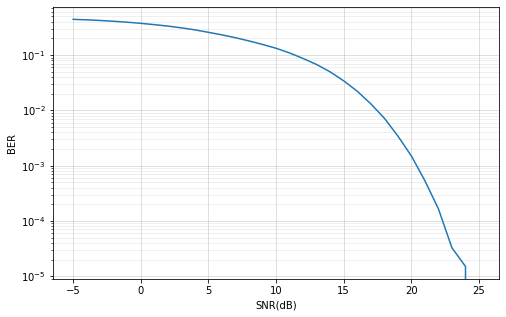

In [258]:
plt.figure(figsize=(8, 5))
plt.semilogy(snr_range, results)
plt.xlabel('SNR(dB)')
plt.ylabel('BER');
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.25)

# See learned constellation

In [261]:
# Form a batch containing every bit vector
bin_vec = tf.constant([[0], [1]])
block = bit_vec = bin_vec
for i in range(1, K):
    C1 = tf.reshape(tf.tile(bin_vec, [1, tf.pow(2, i)]), [-1, 1])
    C2 = tf.tile(block, [2, 1])
    bit_vec = tf.concat([C1, C2], axis=1)
    block = bit_vec
    
batch_snr = training_snr*tf.ones(shape=[tf.shape(bit_vec)[0], 1])

p_b = autoencoder([bit_vec, batch_snr])

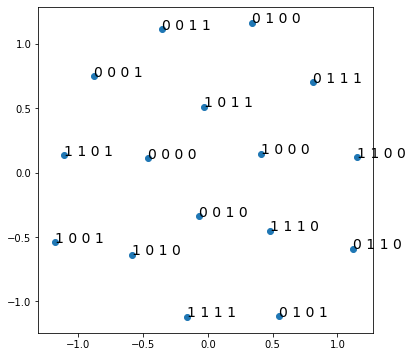

In [292]:
bit_vec_np = bit_vec.numpy()
x_np = autoencoder.x.numpy()
plt.figure(figsize=(6,6))
plt.scatter(np.real(x_np), np.imag(x_np))
for i in range(np.shape(x_np)[0]) :
    plt.text(np.real(x_np[i]), np.imag(x_np[i]), str(bit_vec_np[i])[1:-1], fontsize=14)